## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
# ваш код здесь
data.info()
date_type = data.dtypes['date']
print('Тип данных колонки "date" - ', date_type)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB
Тип данных колонки "date" -  object


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
# ваш код здесь
data['date'] = pd.to_datetime(data['date'])
print('Дата начала эксперимента - ',data['date'].min(), '\n', 'Дата завершения эксперимента - ', data['date'].max())

Дата начала эксперимента -  2021-01-02 00:00:00 
 Дата завершения эксперимента -  2021-01-24 00:00:00


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
# ваш код здесь
print('Количество посещений сайта - А', data[data['group'] == 'A']['user_id'].count())
print('Количество посещений сайта - B', data[data['group'] == 'B']['user_id'].count())
print('Суммарное количество покупок А ', data[data['group'] == 'A']['purchase'].sum())
print('Суммарное количество покупок B ', data[data['group'] == 'B']['purchase'].sum())
print('Сумма всех покупок А - ', data[data['group'] == 'A']['price'].sum()/1000000, 'млн.руб.')
print('Сумма всех покупок B - ', data[data['group'] == 'B']['price'].sum()/1000000, 'млн.руб.')

Количество посещений сайта - А 147202
Количество посещений сайта - B 147276
Суммарное количество покупок А  17723
Суммарное количество покупок B  17514
Сумма всех покупок А -  1436.26 млн.руб.
Сумма всех покупок B -  1554.1 млн.руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
# ваш код здесь
group_A = set(data[data['group'] == 'A']['user_id'])
group_B = set(data[data['group'] == 'B']['user_id'])
inter = group_A.intersection(group_B)
print('Количество пользователей, попавших в обе группы: ', len(inter))

Количество пользователей, попавших в обе группы:  1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in inter)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

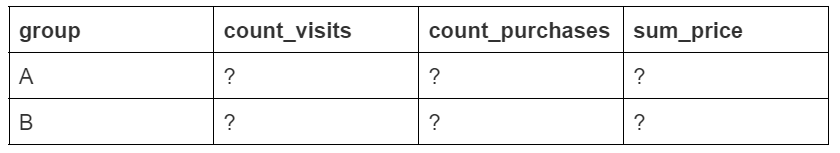
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
# ваш код здесь
group_data = updated_data.groupby(by='group').agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).reset_index()
group_data = group_data.rename(columns={'user_id':'count_visits', 
                                        'purchase':'count_purchases', 'price':'sum_price'})
group_data

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

ваши выводы здесь:  
1. Количество покупателей, покупок и сумм являются сопоставивыми.  
2. Данных достаточно.  
3. Мы можем говорить о сбалансированности выборки

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
# ваш код здесь
group_data['conversion'] = round((group_data['count_purchases'] / group_data['count_visits'] * 100), 2)
group_data['mean_check'] = round(group_data['sum_price'] / group_data['count_purchases'])
group_data

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

ваши выводы здесь:  
1. Конверсия в группе А выше, НО  
2. Средний чек, как и общая сумма покупок в группе В больше. То есть покупатели покупают реже, но на большие суммы.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
# ваш код здесь
pivot_data = pd.pivot_table(updated_data, values='purchase', columns='group', index='price', aggfunc='sum')

pivot_data

group,A,B
price,,
0,0,0
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

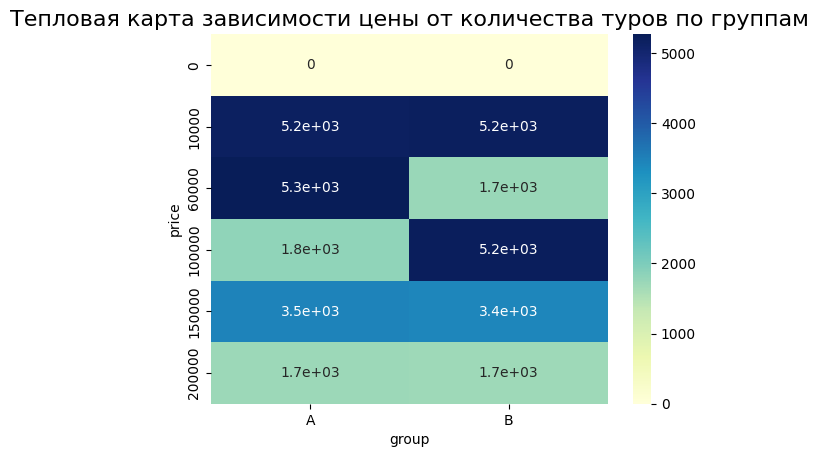

In [11]:
# ваш код здесь
# сначала надо убрать клиентов, которые зашли, но ничего не купили

heatmap = sns.heatmap(data=pivot_data, cmap='YlGnBu', annot=True)
heatmap.set_title('Тепловая карта зависимости цены от количества туров по группам', fontsize=16);

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

ваши выводы здесь:  
1. Туры за 60000 руб (в Турцию) в группе А более популярны, чем в группе В.
2. Туры за 100 тыс. руб. (в Таиланд) более популярны в группе В, чем в группе А.
3. Остальные предпочтения по турам примерно совпадают.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
# ваш код здесь
group_by_date = updated_data.groupby(by=['date','group']).agg({'user_id':'count', 
                                                               'purchase':'sum', 'price':'sum'}).reset_index()
group_by_date['conversion'] = round((group_by_date['purchase'] / group_by_date['user_id'] * 100), 2)
group_by_date['mean_check'] = round(group_by_date['price']/group_by_date['purchase'])
group_by_date[group_by_date['date'] == '2021-01-03']

,date,group,user_id,purchase,price,conversion,mean_check
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
# ваш код здесь
group_A = group_by_date[group_by_date['group'] == 'A']
group_B = group_by_date[group_by_date['group'] == 'B']
group_A['cum_users'] = group_A['user_id'].cumsum()
group_A['cum_purchases'] = group_A['purchase'].cumsum()
group_A['cum_price'] = group_A['price'].cumsum()
group_A['cum_conversion'] = round((group_A['cum_purchases'] / group_A['cum_users'] * 100), 2)
group_A['cum_mean_check'] = round(group_A['cum_price']/group_A['cum_purchases'])

group_B['cum_users'] = group_B['user_id'].cumsum()
group_B['cum_purchases'] = group_B['purchase'].cumsum()
group_B['cum_price'] = group_B['price'].cumsum()
group_B['cum_conversion'] = round((group_B['cum_purchases'] / group_B['cum_users'] * 100), 2)
group_B['cum_mean_check'] = round(group_B['cum_price']/group_B['cum_purchases'])

print('Кумулятивная конверсия в группе B на 20 января = ', 
      group_B[group_B['date'] == '2021-01-20']['cum_conversion'])
print('Кумулятивный средний чек в группе А на 12 января 2021 года = ', 
      group_A[group_A['date'] == '2021-01-12']['cum_mean_check'])



Кумулятивная конверсия в группе B на 20 января =  37    11.9
Name: cum_conversion, dtype: float64
Кумулятивный средний чек в группе А на 12 января 2021 года =  20    81492.0
Name: cum_mean_check, dtype: float64


C:\Users\u1\AppData\Local\Temp\ipykernel_10508\3736985263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_A['cum_users'] = group_A['user_id'].cumsum()
C:\Users\u1\AppData\Local\Temp\ipykernel_10508\3736985263.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_A['cum_purchases'] = group_A['purchase'].cumsum()
C:\Users\u1\AppData\Local\Temp\ipykernel_10508\3736985263.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

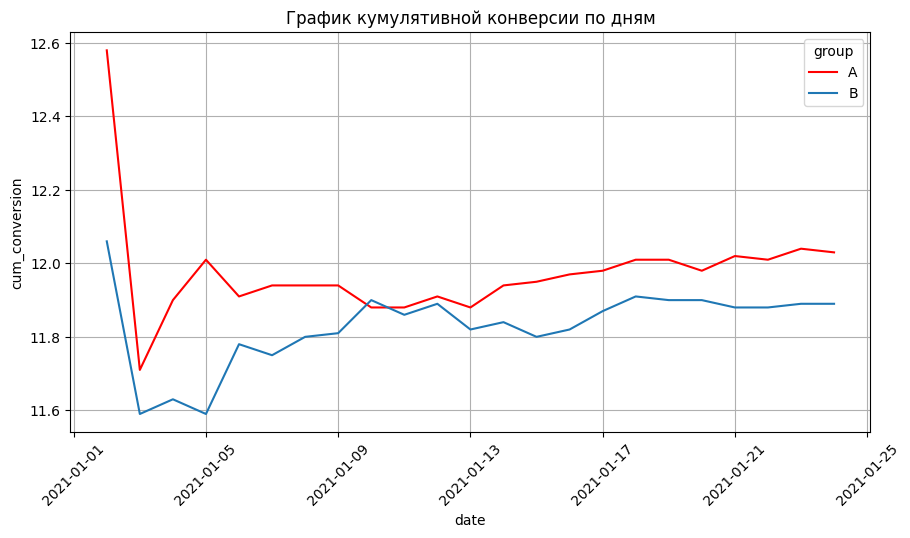

In [14]:
# ваш код здесь
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=group_A, hue='group', ax=ax, palette=['red'])
sns.lineplot(x='date', y='cum_conversion', data=group_B, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

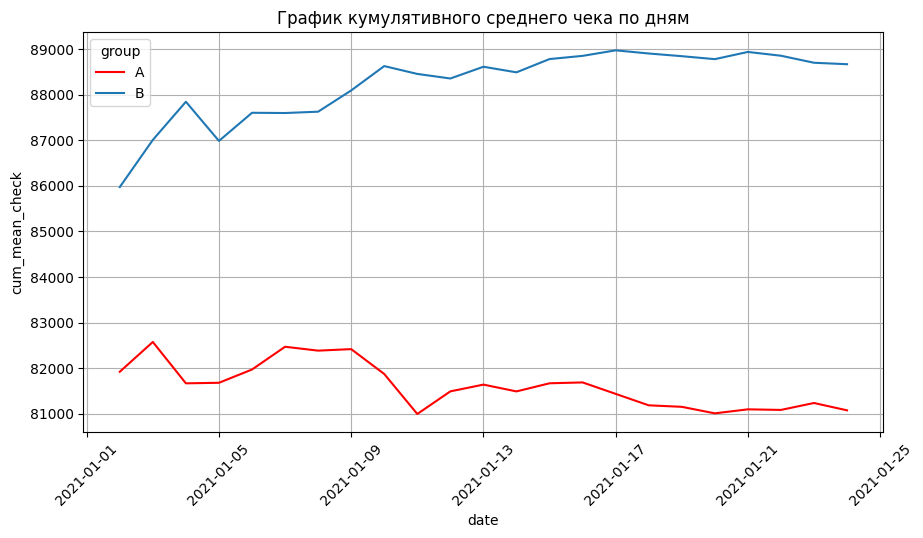

In [15]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=group_A, hue='group', ax=ax, palette=['red'])
sns.lineplot(x='date', y='cum_mean_check', data=group_B, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

ваши выводы здесь  
1. График куммулятивной конверсии показывает, что изначально дневные показатели сильно скакали, и только применение куммулятивного метода позволило стабилизировать график. Примерно после 17 января графики успокоились, стабилизировались и стали отражать реальную конверсию в группах.
2. Конверсия в группе А выше, по сравнению с группой В. При этом разница в пределах нескольких десятых долях процента.
3. Аналогичная ситуация по графику коммулятивного среднего чека. Графики стабилизировались.
4. График коммулятивного среднего чека наглядно показывает, что средний чек в группе В выше, чем в группе А, примерно на 7000 рублей.
5. Исходя из графиков, можно сделать вывод, что А/В тест можно считать завершенным.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [16]:
# ваш код здесь
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=group_data['count_purchases'], #число "успехов"
    nobs=group_data['count_visits'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Выводы теста говорят сами за себя, показатели конверсии в группах А и В не имеют статистической разницы, то есть конверсии в обеих группах статистически равны

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [17]:
updated_data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


In [18]:
# ваш код здесь
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']


conf_interval_a = proportions_conf_interval(
n=a_data['purchase'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['purchase'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [19]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [a_data['purchase'].count(), b_data['purchase'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

**Левая граница доверительного интервала отрицательная, а правая — положительная. То есть истинная разница в конверсии  может быть как положительной, так и отрицательной. Это значит, что варианты А и B равнозначны по метрике конверсии.**

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [20]:
# ваш код здесь
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05
from scipy.stats import shapiro
_, p = shapiro(group_A['mean_check'])
print('p=%.3f' % p)
# Интерпретация 
if p > alpha:
	print(H0)
else:
	print(Ha)
 
_, p = shapiro(group_B['mean_check'])
print('p=%.3f' % p)
# Интерпретация 
if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.253
Данные распределены нормально
p=0.094
Данные распределены нормально


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [21]:
group_by_date

,date,group,user_id,purchase,price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.58,81922.0
1,2021-01-02,B,2861,345,29660000,12.06,85971.0
2,2021-01-03,A,6596,748,62000000,11.34,82888.0
3,2021-01-03,B,6619,754,65960000,11.39,87480.0
4,2021-01-04,A,6566,799,64250000,12.17,80413.0
5,2021-01-04,B,6536,764,68030000,11.69,89045.0
6,2021-01-05,A,6433,790,64550000,12.28,81709.0
7,2021-01-05,B,6511,749,63550000,11.50,84846.0
8,2021-01-06,A,6606,764,63410000,11.57,82997.0
9,2021-01-06,B,6751,838,75020000,12.41,89523.0


In [22]:
# ваш код здесь
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 # уровень значимости

#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=group_by_date[group_by_date['group'] == 'A']['mean_check'],
    b=group_by_date[group_by_date['group'] == 'B']['mean_check'], 
    alternative='less'
)
print('p-value:', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 1.1275579271768679e-12
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

**Так как p-value меньше уровня значимости, мы не можем принять нулевую гипотезу.**
**Мы делаем вывод о том, что разница в средних чеках в разных группах статистически значима, а именно в группе А средний чек ниже, чем в группе В.**

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [23]:
group_A['user_id'].count()

23

In [24]:
# ваш код здесь
n = group_A['user_id'].count() # размер выборки
k = n - 1 # число степеней свободы
x_mean = group_A['mean_check'].mean() # выборочное среднее
x_std = group_A['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал группы А: {}'.format(confidence_interval)) # выводим результат

n = group_B['user_id'].count() # размер выборки
k = n - 1 # число степеней свободы
x_mean = group_B['mean_check'].mean() # выборочное среднее
x_std = group_B['mean_check'].std() # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал группы B: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал группы А: (79630, 82308)
Доверительный интервал группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Пересечений в доверительных интервалах в группах А и В нет, следовательно результаты статистически значимы: средний чек в группе В выше ,чем в группе А!


## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

**ВЫВОДЫ**
1. Предпочтительным вариантом дизайна является вариант B.
2. Хоть конверсия в обеих исследуемых группах не имеет статистической разницы, однако средний чек в группе В выше и данный показатель статистически значим. Так как при прочих равных средний чек влечет увеличение доходов, то второй вариант дизайна (новый) рекомендуется использовать на сайте компании.

In [29]:
df = pd.read_csv('data/new-site.csv', sep='\t')
df

,site,dwell-time
0,0,2
1,1,48
2,0,15
3,1,16
4,0,38
...,...,...
295,0,22
296,0,7
297,1,144
298,0,89


In [30]:
print(round(df[df['site'] == 0]['dwell-time'].mean()))
print(df[df['site'] == 1]['dwell-time'].mean())

91
88.0


In [31]:
df0 = df[df['site'] == 0]
df1 = df[df['site'] == 0]

In [32]:
# ваш код здесь
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05
from scipy.stats import shapiro
_, p = shapiro(df0['dwell-time'])
print('p=%.3f' % p)
# Интерпретация 
if p > alpha:
	print(H0)
else:
	print(Ha)
 
_, p = shapiro(df1['dwell-time'])
print('p=%.3f' % p)
# Интерпретация 
if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)
p=0.000
Данные не распределены нормально (мы отвергаем H0)
